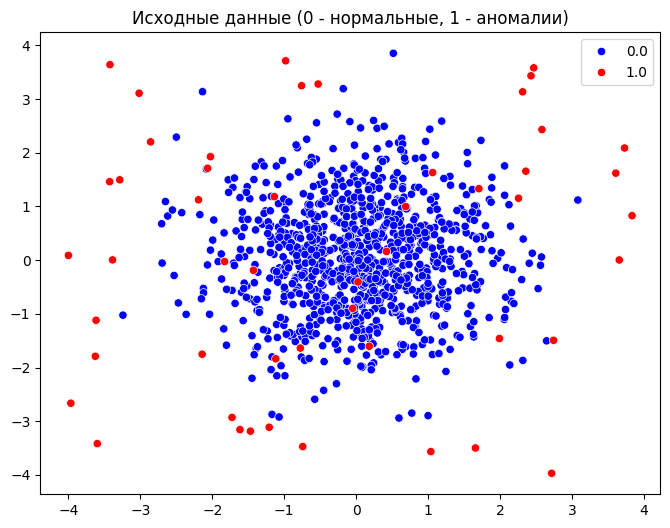

One-Class SVM:
Лучшие параметры One-Class SVM: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Classification Report for One-Class SVM
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90       300
         1.0       0.16      0.60      0.25        15

    accuracy                           0.83       315
   macro avg       0.57      0.72      0.57       315
weighted avg       0.94      0.83      0.87       315

Accuracy: 0.8253968253968254

Isolation Forest:
Лучшие параметры Isolation Forest: {'contamination': 0.05, 'max_samples': 'auto', 'n_estimators': 50}
Classification Report for Isolation Forest
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       300
         1.0       0.50      0.60      0.55        15

    accuracy                           0.95       315
   macro avg       0.74      0.78      0.76       315
weighted avg       0.96      0.95      0.95       315

Accuracy: 0.952380

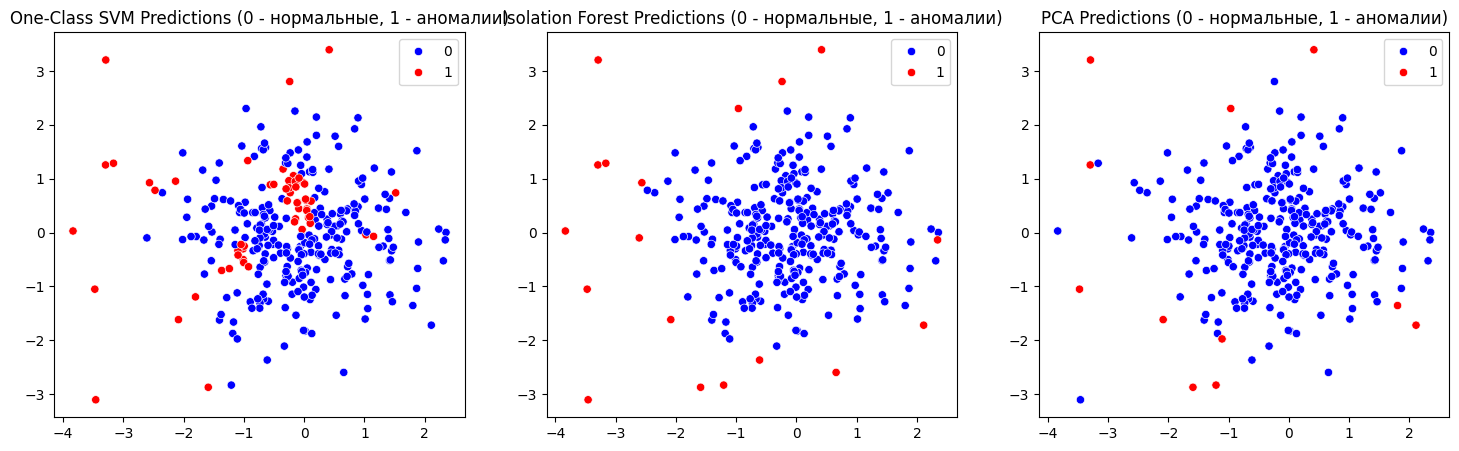

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Генерация искусственных данных
np.random.seed(42)
n_samples = 1000
n_anomalies = 50

# Нормальные транзакции (многомерное нормальное распределение)
X_normal = np.random.normal(0, 1, (n_samples, 2))

# Аномальные транзакции (отличающееся распределение)
X_anomalies = np.random.uniform(low=-4, high=4, size=(n_anomalies, 2))

# Объединяем нормальные и аномальные транзакции в единый набор данных
X = np.vstack([X_normal, X_anomalies])
y = np.hstack([np.zeros(n_samples), np.ones(n_anomalies)])  # 0 - нормальные, 1 - аномалии

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Визуализация данных
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=["blue", "red"])
plt.title("Исходные данные (0 - нормальные, 1 - аномалии)")
plt.show()

# 1. Настройка One-Class SVM с использованием кросс-валидации
print("One-Class SVM:")
param_grid_svm = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
oc_svm = OneClassSVM()
grid_search_svm = GridSearchCV(oc_svm, param_grid_svm, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_svm.fit(X_train, np.zeros(X_train.shape[0]))  # Обучаем только на нормальных данных
oc_svm_best = grid_search_svm.best_estimator_

y_pred_ocsvm = oc_svm_best.predict(X_test)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)  # Метка -1 — аномалии

print("Лучшие параметры One-Class SVM:", grid_search_svm.best_params_)
print("Classification Report for One-Class SVM")
print(classification_report(y_test, y_pred_ocsvm))
print("Accuracy:", accuracy_score(y_test, y_pred_ocsvm))

# 2. Настройка изолирующего леса с использованием кросс-валидации
print("\nIsolation Forest:")
param_grid_iso = {
    'n_estimators': [50, 100, 200],
    'contamination': [0.05, 0.1, 0.15],
    'max_samples': ['auto', 0.6, 0.9]
}
iso_forest = IsolationForest(random_state=42)
grid_search_iso = GridSearchCV(iso_forest, param_grid_iso, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_iso.fit(X_train, np.zeros(X_train.shape[0]))
iso_forest_best = grid_search_iso.best_estimator_

y_pred_iso = iso_forest_best.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Метка -1 — аномалии

print("Лучшие параметры Isolation Forest:", grid_search_iso.best_params_)
print("Classification Report for Isolation Forest")
print(classification_report(y_test, y_pred_iso))
print("Accuracy:", accuracy_score(y_test, y_pred_iso))

# 3. PCA для обнаружения аномалий
print("\nPCA Anomaly Detection:")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Восстановление данных и оценка ошибки восстановления
X_train_pca_inv = pca.inverse_transform(X_train_pca)
X_test_pca_inv = pca.inverse_transform(X_test_pca)

# Оценка ошибки восстановления для обнаружения аномалий
mse = np.mean((X_test - X_test_pca_inv) ** 2, axis=1)
threshold = np.percentile(mse, 95)  # Порог на основе 95-го перцентиля MSE
y_pred_pca = np.where(mse > threshold, 1, 0)  # 1 — аномалии, 0 — нормальные

print("Classification Report for PCA")
print(classification_report(y_test, y_pred_pca))
print("Accuracy:", accuracy_score(y_test, y_pred_pca))

# Визуализация результатов обнаружения аномалий
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Визуализация One-Class SVM
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_ocsvm, palette=["blue", "red"], ax=axes[0])
axes[0].set_title("One-Class SVM Predictions (0 - нормальные, 1 - аномалии)")

# Визуализация Isolation Forest
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_iso, palette=["blue", "red"], ax=axes[1])
axes[1].set_title("Isolation Forest Predictions (0 - нормальные, 1 - аномалии)")

# Визуализация PCA
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_pca, palette=["blue", "red"], ax=axes[2])
axes[2].set_title("PCA Predictions (0 - нормальные, 1 - аномалии)")

plt.show()
